## Read wind speed and direction from the input file 

In [10]:
# Load functions
import scipy.io
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Load the MATLAB file
mat = scipy.io.loadmat('..\data\Terminos_lagoon_wind_surface_forcing.mat')

# Extract time, U, and V components
matlab_time = mat['Time'].flatten()  # Assuming 'Time' is a 1D array
U = mat['XX'].flatten()              # Assuming 'XX' is a 1D array
V = mat['YY'].flatten()              # Assuming 'YY' is a 1D array

# Convert MATLAB time to Python datetime
python_time = [datetime.fromordinal(int(t)) + timedelta(days=t%1) - timedelta(days=366) for t in matlab_time]

# Create a DataFrame
df = pd.DataFrame({'time': python_time, 'U': U, 'V': V})

In [11]:
import scipy.io
import pandas as pd
from datetime import datetime, timedelta

# Load the MATLAB file
mat = scipy.io.loadmat('..\data\Terminos_lagoon_wind_surface_forcing.mat')

# Extract time, U, and V components
matlab_time = mat['Time'].flatten()
U = mat['XX'].flatten()
V = mat['YY'].flatten()

# Convert MATLAB time to Python datetime
python_time = [datetime.fromordinal(int(t)) + timedelta(days=t%1) - timedelta(days=366) for t in matlab_time]

# Create a DataFrame
df = pd.DataFrame({'time': python_time, 'U': U, 'V': V})

## Calculate the resultant wind speed and direction. 

### The wind direction is going towards (oceanographic convention)

In [12]:
from metpy.calc import wind_direction, wind_speed
from metpy.units import pandas_dataframe_to_unit_arrays

# Define units for U and V components
wind_units = {'U': 'm/s', 'V': 'm/s'}

# Convert the DataFrame to unit arrays and calculate wind speed and direction
unit_arrays = pandas_dataframe_to_unit_arrays(df, column_units=wind_units)
df['wind_speed_m_s'] = wind_speed(unit_arrays['U'], unit_arrays['V']).magnitude
df['wind_direction_degree'] = wind_direction(unit_arrays['U'], unit_arrays['V'], convention="to").magnitude


## Plot wind direction  and wind speed histogram.

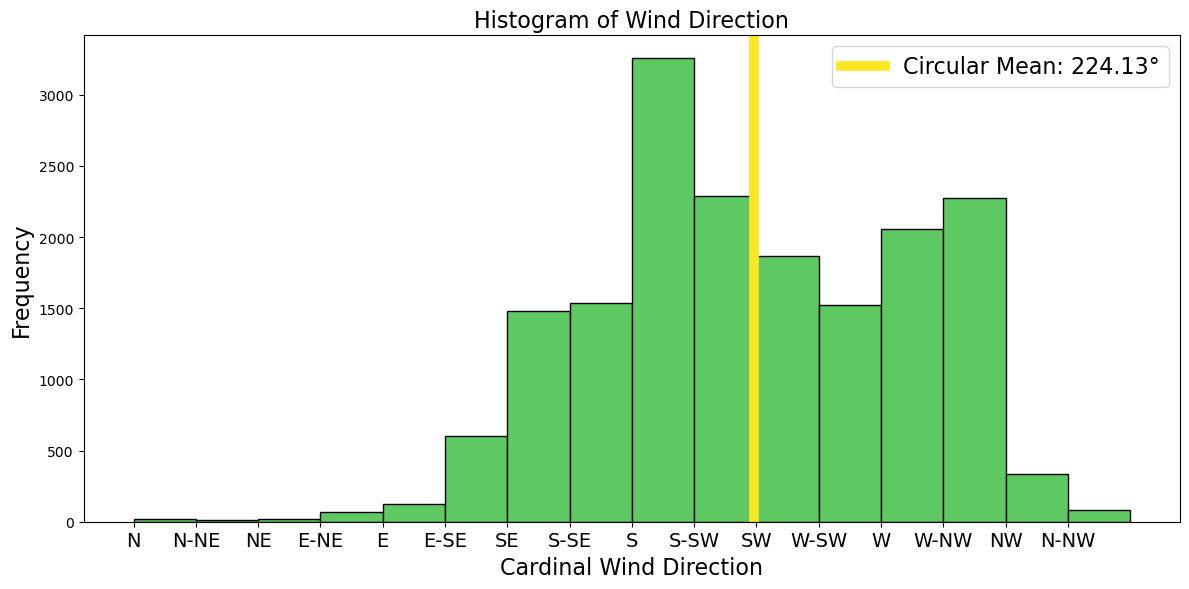

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean

# Calculate circular mean for wind direction
circular_mean = circmean(df['wind_direction_degree'], high=360, low=0)

# Plot histogram for wind direction
plt.figure(figsize=(12, 6))
plt.hist(df['wind_direction_degree'], bins=np.arange(0, 361, 22.5), 
         edgecolor='black', color='#5ec962')

# Set xticks and labels
xlabels = ["N", "N-NE", "NE", "E-NE", "E", "E-SE", "SE", "S-SE", 
           "S", "S-SW", "SW", "W-SW", "W", "W-NW", "NW", "N-NW"]
xticks = np.arange(0, 360, 22.5)
plt.xticks(xticks, xlabels, fontsize=14)

# Add labels and title
plt.xlabel('Cardinal Wind Direction', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Wind Direction', fontsize=16)

# Plot circular mean
plt.axvline(circular_mean, color='#fde725', linestyle='-', linewidth=7, 
            label=f'Circular Mean: {circular_mean:.2f}°')

# Add legend
plt.legend(loc='upper right', fontsize=16)

# Save and show the figure
plt.tight_layout()
plt.savefig('..\output_files\wind_direction_histogram.pdf', dpi=600)
plt.show()

In [16]:
# To calculate circular statistics, 
from scipy.stats import circmean,  circstd

# Calculate circular statistics for wind direction
circular_mean = circmean(df['wind_direction_degree'], high=360, low=0)
circular_std = circstd(df['wind_direction_degree'], high=360, low=0)

# Print circular statistics
print(f'Circular Mean: {circular_mean:.2f}°')
print(f'Circular Standard Deviation: {circular_std:.2f}°')

Circular Mean: 224.13°
Circular Standard Deviation: 58.37°


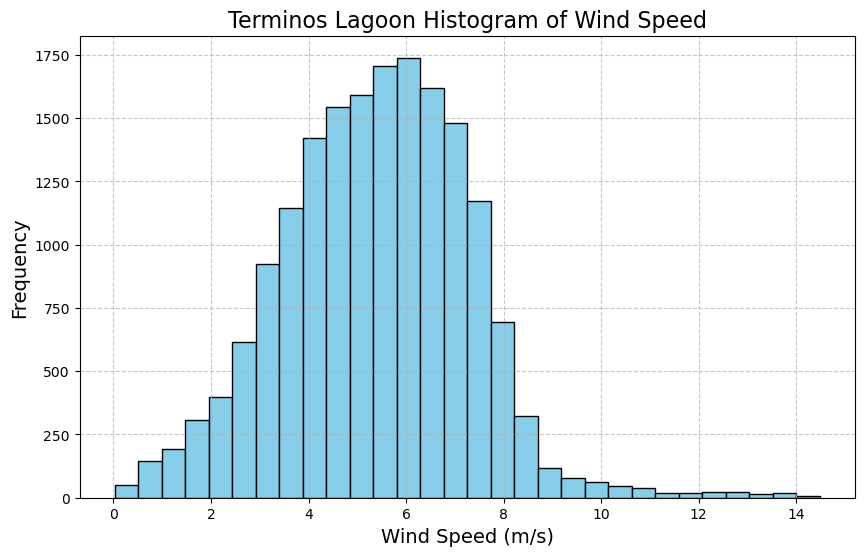

In [17]:
# Plot histogram of wind speed
plt.figure(figsize=(10, 6))
plt.hist(df['wind_speed_m_s'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Terminos Lagoon Histogram of Wind Speed', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Plot windrose diagram.


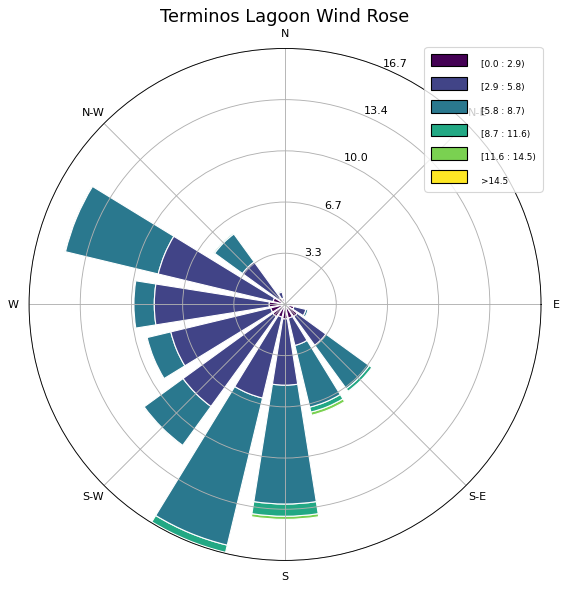

In [18]:
from windrose import WindroseAxes

wind_direction = df['wind_direction_degree']  # My wind direction data
wind_speed = df['wind_speed_m_s']  # My wind speed data

ax = WindroseAxes.from_ax()

ax.bar(
    wind_direction, wind_speed, normed=True,
    edgecolor='white')  
    

ax.set_legend(loc='upper right', fontsize=16)


ax.set_title("Terminos Lagoon Wind Rose", fontsize=16)

plt.savefig('..\output_files\\terminos_wind_rose.pdf', dpi=600)

plt.show()




_______________________________________________________________________________________________________________________


## Plot wind direction  and wind speed histogram each month.

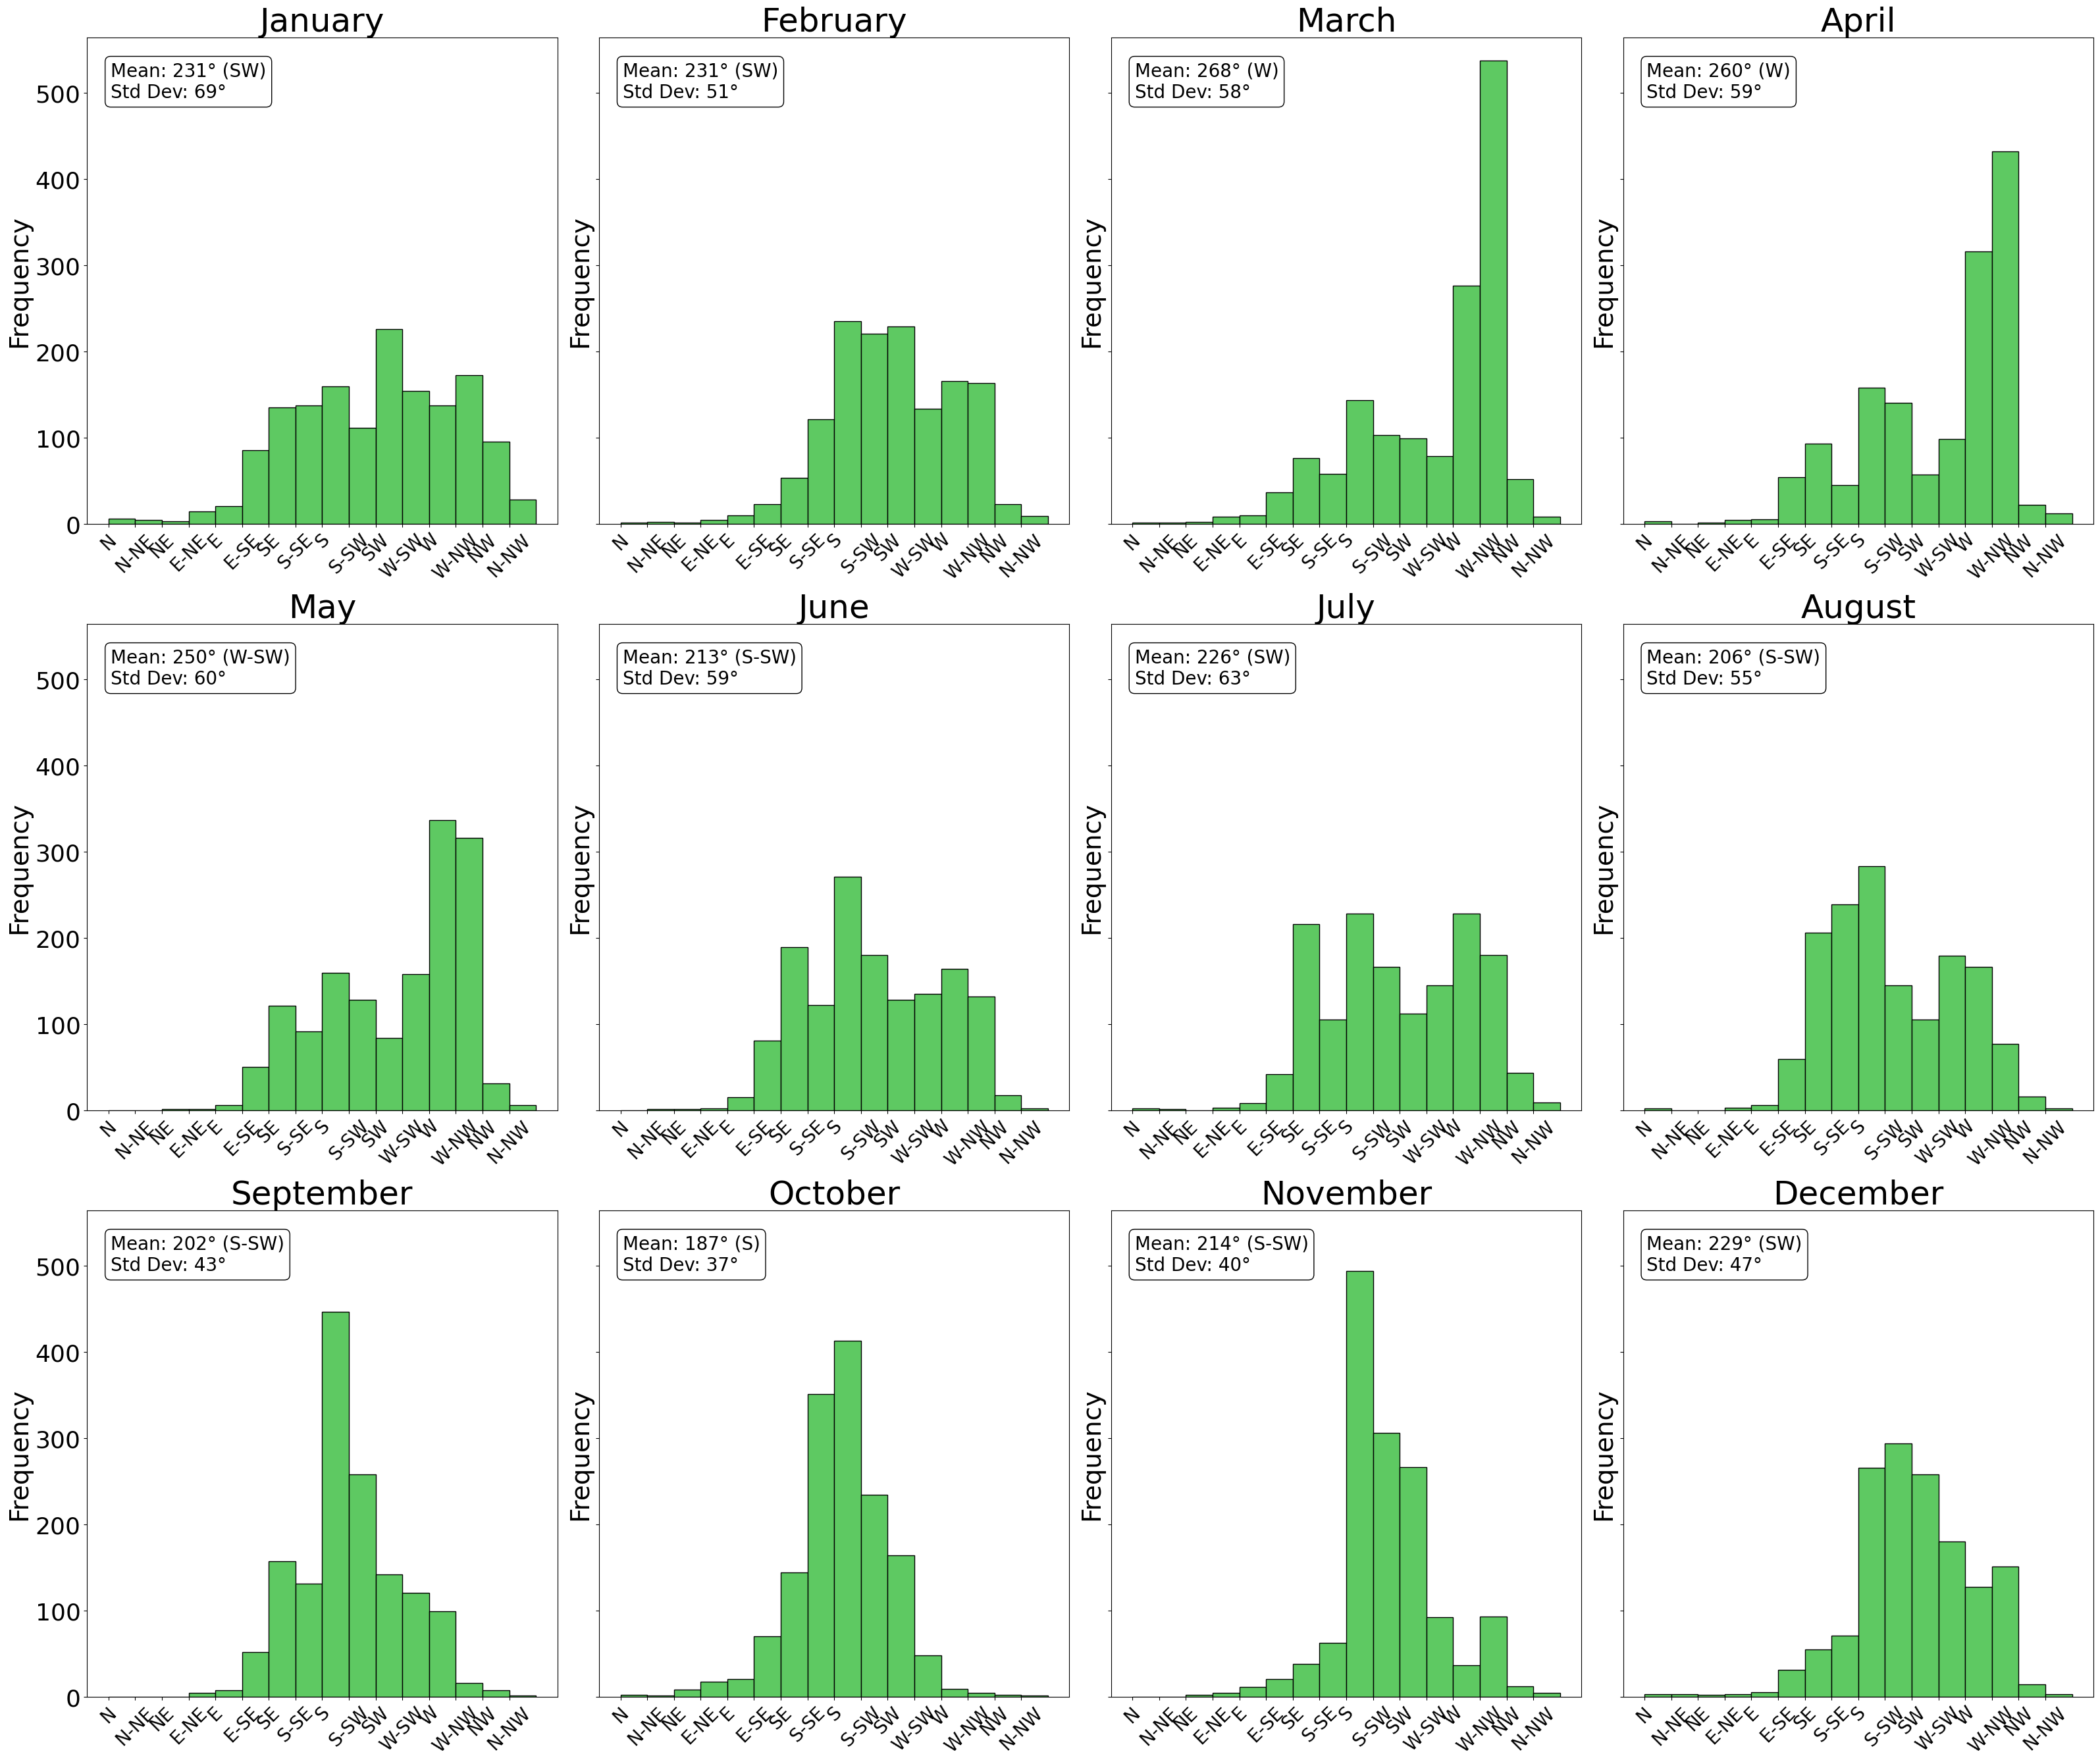

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd

# Extract month from the date
df['Month'] = df['time'].dt.month

# List of month names in English
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Function to convert degrees to cardinal direction
def degrees_to_cardinal(degrees):
    directions = ["N", "N-NE", "NE", "E-NE", "E", "E-SE", "SE", "S-SE", 
                  "S", "S-SW", "SW", "W-SW", "W", "W-NW", "NW", "N-NW"]
    index = int((degrees + 11.25) // 22.5) % 16
    return directions[index]

# Function to plot histogram and add statistics
def plot_monthly_histogram(ax, month, data):
    ax.hist(data['wind_direction_degree'], bins=np.arange(0, 361, 22.5), color='#5ec962', edgecolor='black')
    ax.set_title(month_names[month - 1], fontsize=36)
    ax.set_ylabel('Frequency', fontsize=28)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=20, rotation=45)
    ax.tick_params(axis='y', labelsize=26)
    
    circular_mean = circmean(data['wind_direction_degree'], high=360, low=0)
    circular_std = circstd(data['wind_direction_degree'], high=360, low=0)
    cardinal_direction = degrees_to_cardinal(circular_mean)
    
    stats_text = (f'Mean: {circular_mean:.0f}° ({cardinal_direction})\n'
                  f'Std Dev: {circular_std:.0f}°')
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Set xticks and labels
xlabels = ["N", "N-NE", "NE", "E-NE", "E", "E-SE", "SE", "S-SE", 
           "S", "S-SW", "SW", "W-SW", "W", "W-NW", "NW", "N-NW"]
xticks = np.arange(0, 360, 22.5)

# Plot histograms for each month
fig, axs = plt.subplots(3, 4, figsize=(32, 28), sharey=True)

for month in range(1, 13):
    ax = axs[(month-1)//4, (month-1)%4]
    monthly_data = df[df['Month'] == month]
    plot_monthly_histogram(ax, month, monthly_data)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../output_files/terminos_histogram_each_month.pdf', dpi=600)
plt.show()

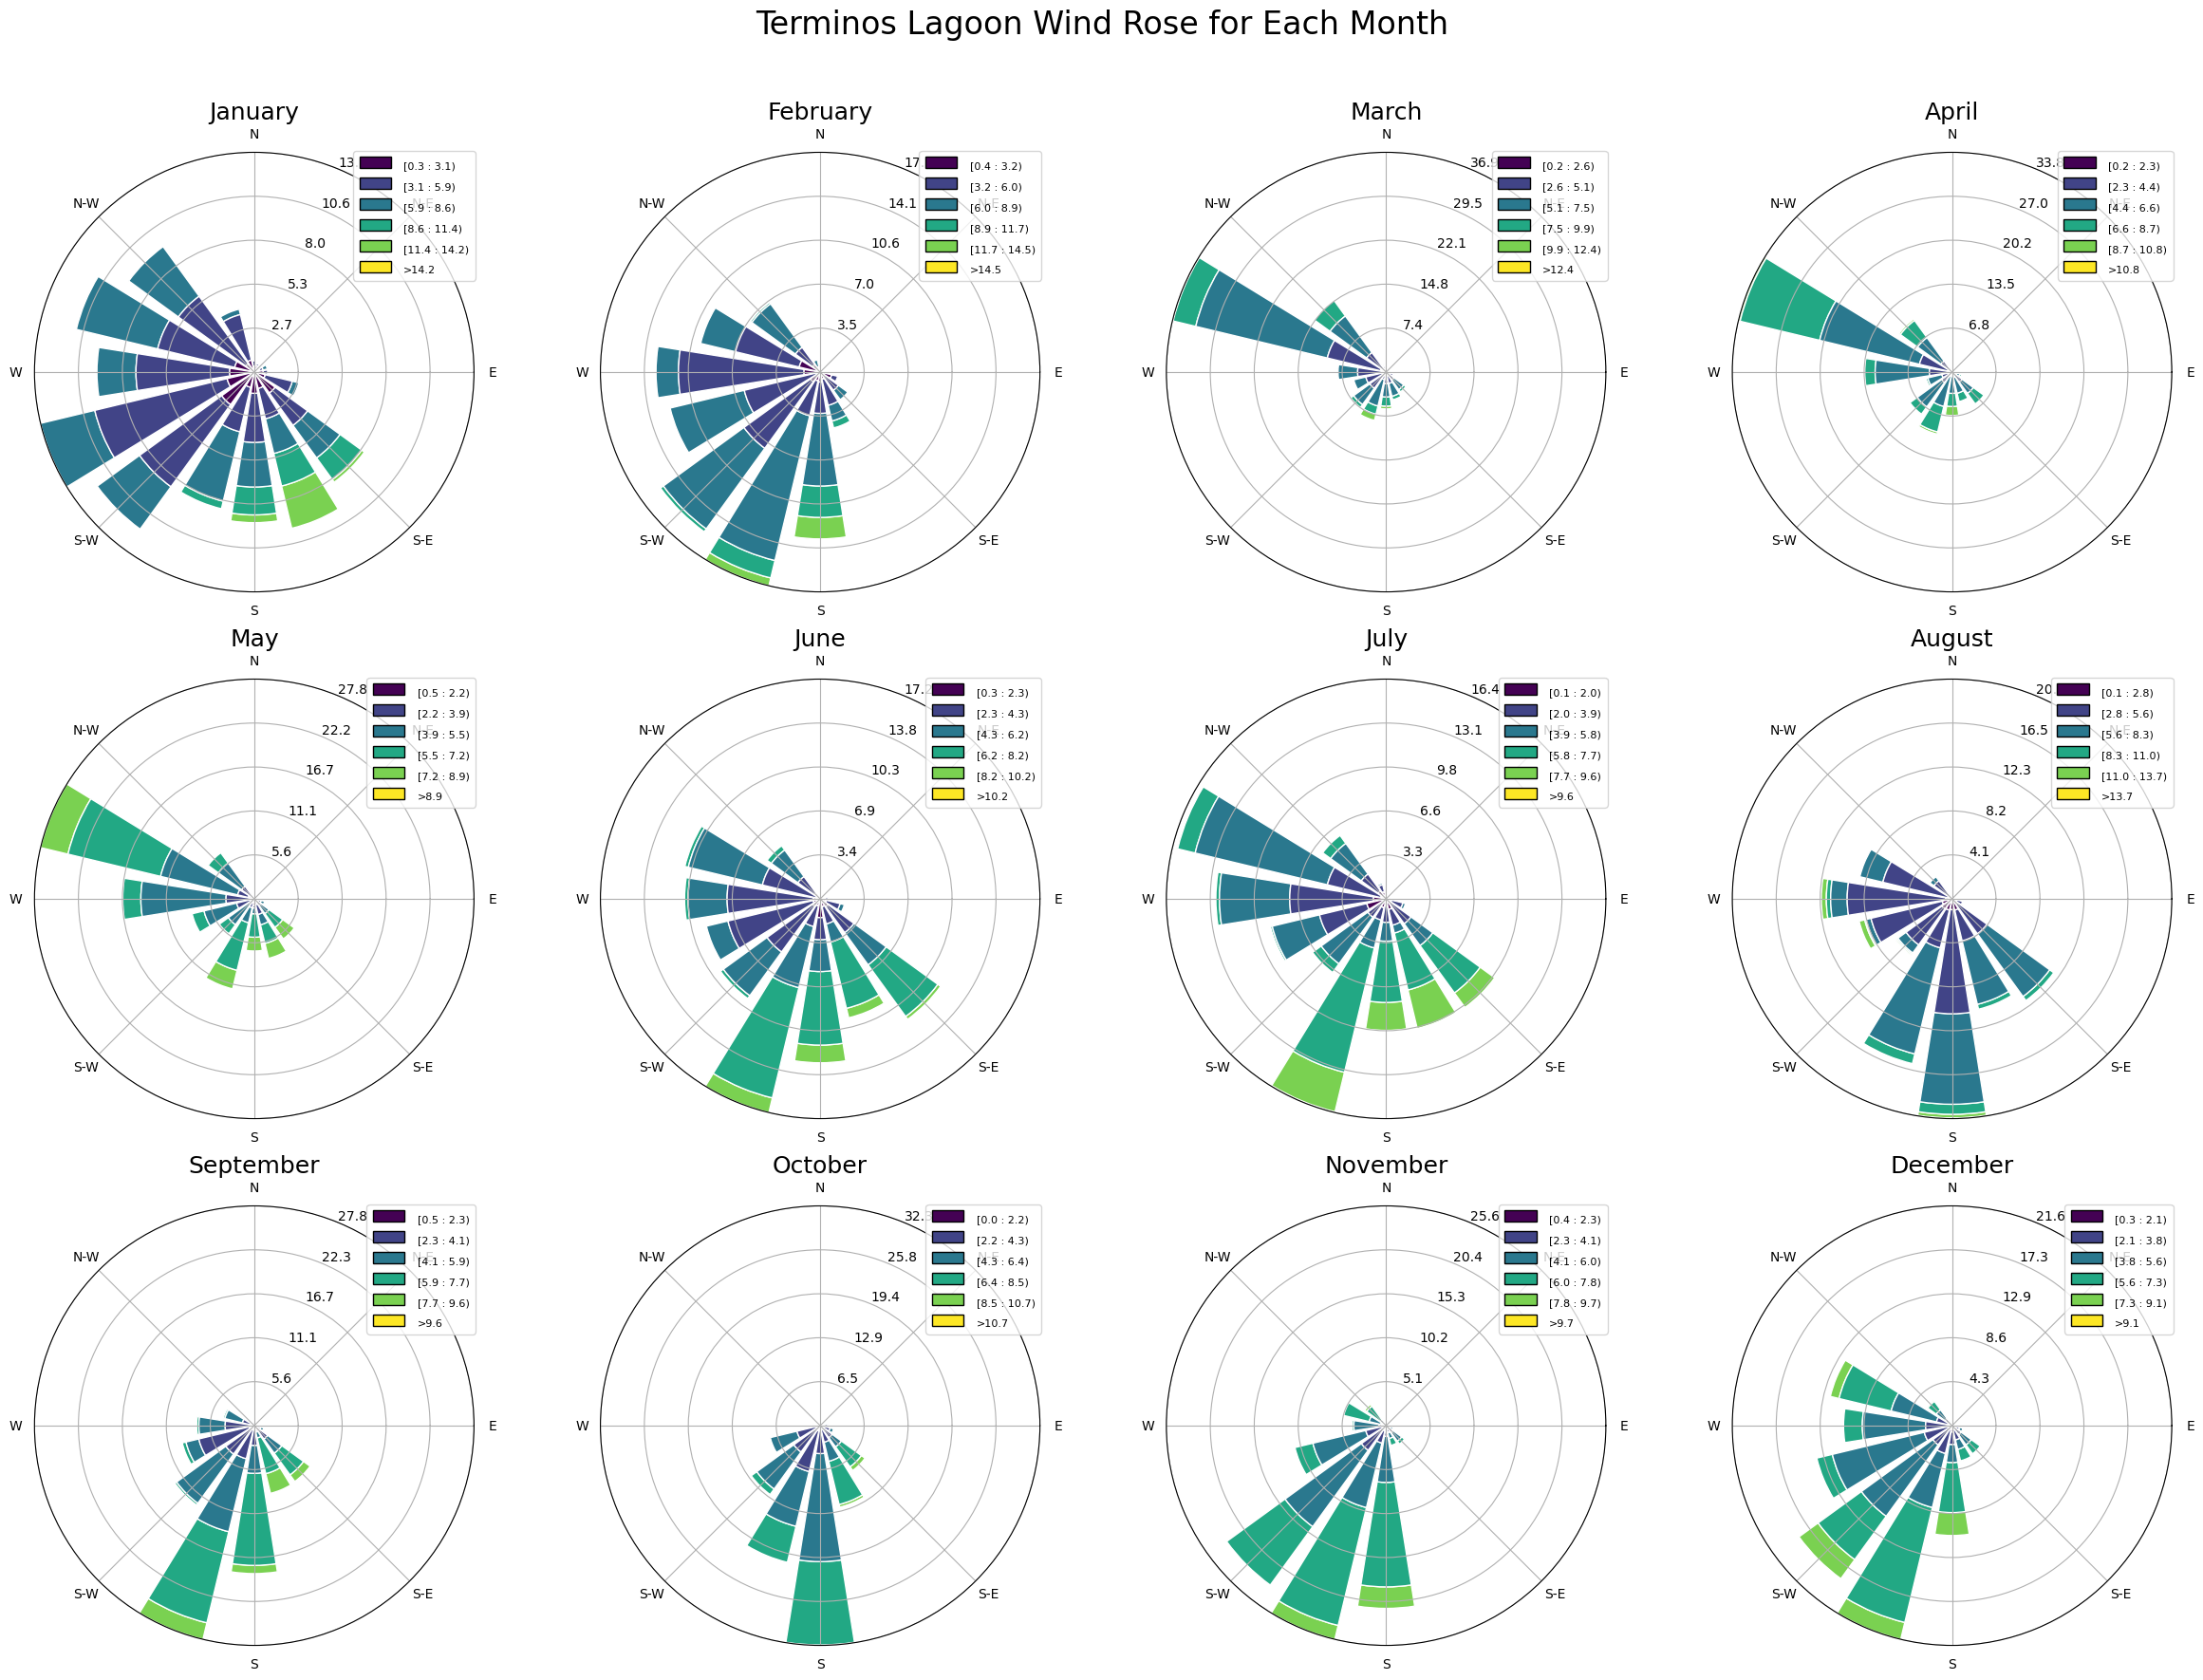

In [19]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import pandas as pd

df['Month'] = df['time'].dt.month

# List of month names in English
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Create subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(24, 18), subplot_kw=dict(projection='windrose'))
fig.suptitle('Terminos Lagoon Wind Rose for Each Month', fontsize=24)

for month in range(1, 13):
    ax = axs[(month-1)//4, (month-1)%4]
    monthly_data = df[df['Month'] == month]
    wind_direction = monthly_data['wind_direction_degree']
    wind_speed = monthly_data['wind_speed_m_s']
    
    ax.bar(wind_direction, wind_speed, normed=True, edgecolor='white')
    ax.set_title(month_names[month - 1], fontsize=18)
    ax.set_legend(loc='upper right', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('..\output_files\\terminos_wind_rose_each_month.pdf', dpi=1200)
plt.show()

___________________________________

## Evaluate the wind speed and direction for each month using Kurscal-Wallis test and post-hoc test.